In [14]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

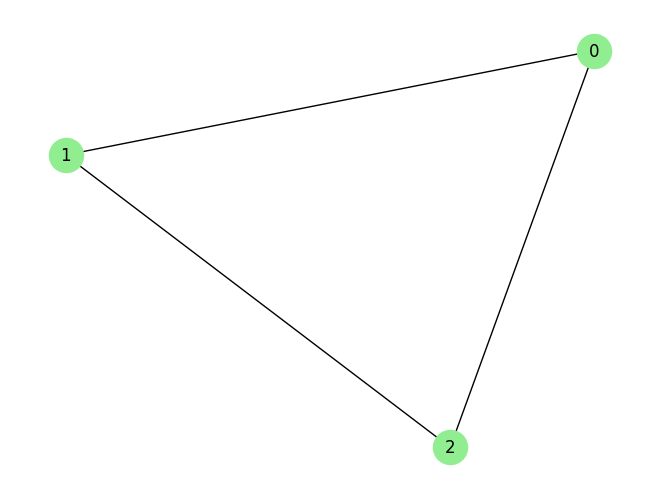

In [15]:
# Parametri
n_nodes = 3
k_colors = 3
edges = [(0, 1), (1, 2), (2, 0)]
graph = nx.Graph()
graph.add_nodes_from(range(n_nodes))
graph.add_edges_from(edges)
positions = nx.spring_layout(graph, seed=1)
#positions = nx.shell_layout(graph)
#positions = nx.kamada_kawai_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color="lightgreen", edge_color="black", node_size=600)
plt.show()

In [16]:
# Trova il nodo con grado minimo
fixed_node = min(graph.degree, key=lambda x: x[1])[0]
fixed_color = 0  

# Bitstring fissa (es. "100" se fixed_color = 0 con k=3)
fixed_bitstring = ["0"] * k_colors
fixed_bitstring[fixed_color] = "1"
fixed_bitstring = "".join(fixed_bitstring)

In [17]:
# Mapping solo per i nodi NON fissati
active_nodes = [n for n in range(n_nodes) if n != fixed_node]
n_qubits = len(active_nodes) * k_colors
wires = list(range(n_qubits))

# Mappa nodo-colore → qubit
def qubit_index(node, color):
    assert node != fixed_node, "Nodo fissato non ha qubit"
    idx = active_nodes.index(node)
    return idx * k_colors + color


In [18]:
# Hamiltoniano di costo
cost_h = 0

# Vincolo one-hot:
for node in range(n_nodes):
    if node == fixed_node:
        continue
    terms = []
    for color in range(k_colors):
        wire = qubit_index(node, color)
        terms.append((qml.Identity(wire) - qml.PauliZ(wire)) / 2)
    sum_x = terms[0]
    for t in terms[1:]:
        sum_x += t
    cost_h += (sum_x @ sum_x - 2 * sum_x + 1)
#cost_h = 1.2*cost_h
    
# Vincolo: nodi adiacenti non devono avere lo stesso colore
for (u, v) in edges:
    # Se u è fisso e v attivo
    if u == fixed_node:
        for color in range(k_colors):
            if color == fixed_color:
                j = qubit_index(v, color)
                penalty = (1 - qml.PauliZ(j)) / 2
                cost_h += penalty
        cost_h = cost_h
        continue
    # Se v  è fisso e u attivo
    if v == fixed_node:
        for color in range(k_colors):
            if color == fixed_color:
                i = qubit_index(u, color)
                penalty = (1 - qml.PauliZ(i)) / 2
                cost_h += penalty
        cost_h = cost_h
        continue
    # Se entrambi sono attivi
    for color in range(k_colors):
        i = qubit_index(u, color)
        j = qubit_index(v, color)
        penalty = (1 - qml.PauliZ(i)) / 2 @ (1 - qml.PauliZ(j)) / 2
        cost_h += penalty


In [19]:
# Hamiltoniano di mixer
mixer_h = 0
for qubit in wires:
    mixer_h += qml.PauliX(qubit)


In [20]:
# QAOA Layer
def qaoa_layer(gamma, alpha):
    qml.ApproxTimeEvolution(cost_h, gamma, 1)
    qml.ApproxTimeEvolution(mixer_h, alpha, 1)


In [21]:
# Circuito
depth = 3
def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])


In [22]:
# Device
dev = qml.device("qulacs.simulator", wires=n_qubits)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)


In [23]:
# Ottimizzazione
optimizer = qml.GradientDescentOptimizer()
#optimizer = qml.AdamOptimizer()
steps = 100
params = np.array([[0.5] * depth, [0.5] * depth], requires_grad=True)

patience = 3           
min_delta = 0.01        
counter = 0
cost_history = []
best_cost = np.inf
best_params = None

for step in tqdm(range(steps), desc="Training Progress"):
    cost = cost_function(params)
    cost_history.append(cost)

    # Early stopping logic
    if best_cost - cost > min_delta:
        best_cost = cost
        best_params = params.copy()
        counter = 0
    else:
        counter += 1

    # Check stop condition
    if counter >= patience:
        print(f"Early stopping at step {step}")
        break

    params = optimizer.step(cost_function, params)

print("Miglior costo trovato:", best_cost)
print("Parametri corrispondenti:", best_params)

Training Progress:   3%|▎         | 3/100 [00:08<04:49,  2.98s/it]


KeyboardInterrupt: 

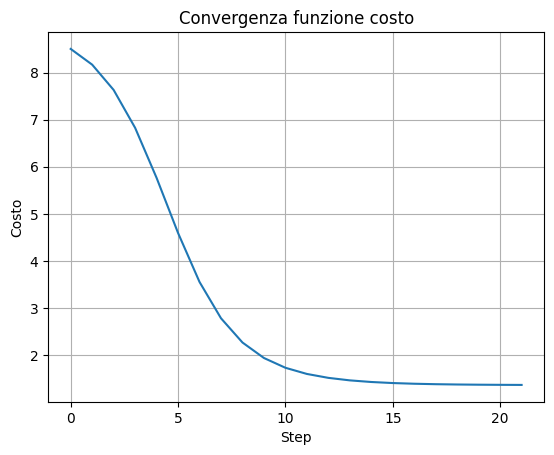

In [ ]:
# Plot convergenza
plt.plot(cost_history)
plt.title("Convergenza funzione costo")
plt.xlabel("Step")
plt.ylabel("Costo")
plt.grid(True)
plt.show()

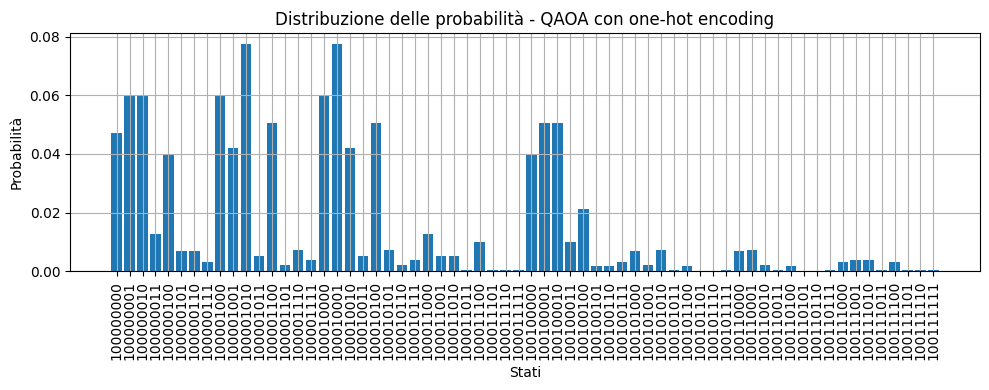

In [ ]:
# Probabilità finali
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(best_params[0], best_params[1])

# Bitstring completa (include nodo fissato)
def insert_fixed_bitstring(raw_bitstring, fixed_node, fixed_bitstring, n_nodes, k_colors):
    chunks = []
    active_index = 0
    for node in range(n_nodes):
        if node == fixed_node:
            chunks.append(fixed_bitstring)
        else:
            start = active_index * k_colors
            end = (active_index + 1) * k_colors
            chunks.append(raw_bitstring[start:end])
            active_index += 1
    return ''.join(chunks)

bitstrings = []
for i in range(2**n_qubits):
    raw = format(i, f"0{n_qubits}b")
    full = insert_fixed_bitstring(raw, fixed_node, fixed_bitstring, n_nodes, k_colors)
    bitstrings.append(full)

# Istogramma
plt.figure(figsize=(10, 4))
plt.bar(bitstrings, probs)
plt.xticks(rotation=90)
plt.xlabel("Stati")
plt.ylabel("Probabilità")
plt.title("Distribuzione delle probabilità - QAOA con one-hot encoding")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
def decode_bitstring(bitstring, n_nodes, k_colors, fixed_node, fixed_color):
    assignment = {fixed_node: [fixed_color]}
    active_index = 0
    for node in range(n_nodes):
        if node == fixed_node:
            continue
        for color in range(k_colors):
            index = active_index * k_colors + color
            if bitstring[index] == '1':
                if node in assignment:
                    assignment[node].append(color)
                else:
                    assignment[node] = [color]
        active_index += 1
        
    return assignment

def is_valid_coloring(assignment, edges):
    # Ogni nodo deve avere esattamente un colore
    for node, colors in assignment.items():
        if len(assignment) != n_nodes or len(colors) != 1:
            return False
    # Nodi adiacenti non devono avere lo stesso colore
    for u, v in edges:
        color_u = assignment.get(u, [-1])[0]
        color_v = assignment.get(v, [-2])[0]
        if color_u == color_v:
            return False
    return True

def analyze_results(probs, n_nodes, k_colors, edges, threshold=np.max(probs)-0.00005):
    print("Bitstring | Assegnamento | Valido | Probabilità")
    print("-" * 50)
    outcome = False
    deg = 0
    for idx, prob in enumerate(probs):
        if prob > threshold:
            bitstring = format(idx, f"0{n_qubits}b")
            assignment = decode_bitstring(bitstring, n_nodes, k_colors, fixed_node, fixed_color)
            valid = is_valid_coloring(assignment, edges)
            bitstring_full = insert_fixed_bitstring(bitstring, fixed_node, fixed_bitstring, n_nodes, k_colors)            
            print(f"{bitstring_full} | {assignment} | {valid} | {prob:.4f}")
            if valid:
                outcome = True
                deg += 1
    return assignment, outcome, deg


assignment, outcome, deg = analyze_results(probs, n_nodes, k_colors, edges)

Bitstring | Assegnamento | Valido | Probabilità
--------------------------------------------------
100001010 | {0: [0], 1: [2], 2: [1]} | True | 0.0775
100010001 | {0: [0], 1: [1], 2: [2]} | True | 0.0775


In [ ]:
#Output: numero cromatico
if outcome:
    print(f"Il numero minimo di colori per colorare il grafo è {k_colors} e si può fare in {deg} modi diversi")
else:
    print(f"{k_colors} NON è il numero cromatico del grafo")

Il numero minimo di colori per colorare il grafo è 3 e si può fare in 2 modi diversi


/home/gigitarasi/Desktop/VSC_WORKSPACE/vEnv/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


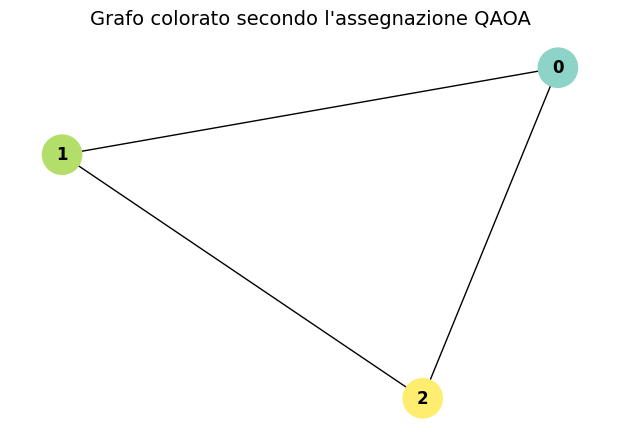

In [ ]:
# Visualizzazione grafo colorato
def plot_colored_graph(graph, assignment, positions, cmap=plt.cm.Set3):
    # Assumiamo che ogni nodo abbia un solo colore
    node_colors = [assignment[n][0] if len(assignment[n]) == 1 else -1 for n in graph.nodes]

    # Crea un elenco dei colori unici
    unique_colors = sorted(set(c for c in node_colors if c != -1))
    
    # Associa ad ogni colore un colore dalla colormap
    n_colors = len(unique_colors)
    color_list = [cmap(i / max(1, n_colors - 1)) for i in range(n_colors)]
    color_map = {c: color_list[i] for i, c in enumerate(unique_colors)}

    # Assegna il colore o grigio se colore non valido
    final_colors = [color_map.get(c, (0.7, 0.7, 0.7)) for c in node_colors]

    plt.figure(figsize=(6, 4))
    nx.draw(
        graph,
        pos=positions,
        with_labels=True,
        node_color=final_colors,
        edge_color="black",
        cmap=cmap,
        node_size=800,
        font_color="black",
        font_weight="bold"
    )
    plt.title("Grafo colorato secondo l'assegnazione QAOA", fontsize=14)
    plt.axis('off')
    plt.show()

plot_colored_graph(graph, assignment, positions)